In [1]:
from itertools import combinations, product

from functools import partial
from multiprocessing import Pool, cpu_count

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon

from neurodsp.spectral import compute_spectrum
from neurodsp.sim import sim_oscillation

from fooof import FOOOF

from timescales.sim import sim_spikes_synaptic
from timescales.fit import fit_psd

In [2]:
def fit_grid_psd(sig, fs, grid, max_n_params=None, n_jobs=-1, chunksize=1):
    
    # Create an array of param grid indices
    param_inds = np.array(list(product(*[list(range(len(i))) for i in list(grid.values())])))
    
    if max_n_params is not None:
        sub_inds = np.random.choice(np.arange(len(param_inds)), max_n_params, replace=False)
        param_inds = param_inds[sub_inds]
        
    # Fit grid
    n_jobs = cpu_count() if n_jobs == -1 else n_jobs
    
    with Pool(processes=n_jobs) as pool:
        
        mapping = pool.imap(partial(_fit_psd, sig=sig, fs=fs, grid=grid),
                            param_inds, chunksize=chunksize)

        params = list(tqdm(mapping, desc='Fitting Spectra', total=len(param_inds)))
           
    return np.array(params)
            
    
def _fit_psd(index, sig=None, fs=None, grid=None):
    """Parallel PSD wrapper."""

    init_params = ['peak_width_limits', 'max_n_peaks', 'peak_threshold']
    self_params = ['knee_freq_bounds', 'exp_bounds']
    spec_params = ['nperseg', 'noverlap']
    
    init_kwargs = {}
    self_kwargs = {}
    spec_kwargs = {}
    
    for (k, v), ind in zip(grid.items(), index):
    
        if k in init_params:
            init_kwargs[k] = v[ind]
        elif k in spec_params:
            spec_kwargs[k] = v[ind]
        elif k in self_params:
            self_kwargs[k] = v[ind]
        elif k == 'freq_range':
            f_range = tuple(v[ind])
    
    # Compute spectrum
    freqs, powers = compute_spectrum(sig, fs, f_range=f_range, **spec_kwargs)
    
    # Fit
    peak_width_limits = tuple(init_kwargs.pop('peak_width_limits'))
    fm = FOOOF(aperiodic_mode='knee', verbose=False, **init_kwargs)
    
    # Bounds for aperiodic fitting, as: ((offset_low_bound, knee_low_bound, exp_low_bound),
    #                                    (offset_high_bound, knee_high_bound, exp_high_bound))
    knee_low_bound, knee_high_bound = self_kwargs['knee_freq_bounds']
    exp_low_bound, exp_high_bound = self_kwargs['exp_bounds']
    
    fm._ap_bounds = ((-np.inf, knee_low_bound, exp_low_bound),
                     (np.inf, knee_high_bound,exp_high_bound))
    
    fm._ap_guess = (None, (knee_low_bound+knee_high_bound)/2, (exp_low_bound+exp_low_bound)/2)
    
    try:
        fm.fit(freqs, powers, freq_range=f_range)
        knee_freq = fm.get_params('aperiodic', 'knee')
        rsq = fm.r_squared_
    except:
        knee_freq = np.nan
        rsq = np.nan
        
    del fm
    
    return [knee_freq, rsq]

### Simulate

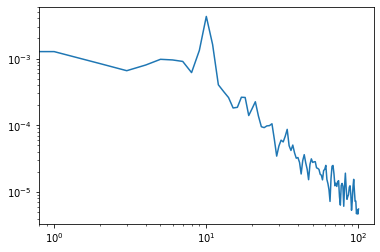

In [3]:
# Add oscillation
np.random.seed(0)

n_seconds = 10
fs = 1000
tau = 0.025
mu = 100
std = 100

isi = expon.rvs(size=int(n_seconds * fs))
isi -= isi.mean()
isi = isi * std + mu
isi = np.round_(isi).astype(int)

probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1, isi=isi, return_sum=False)

# Add oscillation
cos = sim_oscillation(n_seconds, fs, 10, phase='max')
cos -= cos.min()
cos /= cos.max()

sig = probs + (cos * .2)

f, p = compute_spectrum(sig, fs, f_range=(0, 100))
plt.loglog(f, p);

### Fit Grid

In [4]:
specparam_grid = {
    # Init kwargs
    'peak_width_limits': np.array(list(combinations(np.arange(1, 13, 3), 2))),
    'max_n_peaks': np.arange(1, 13, 3),
    'peak_threshold': np.arange(1, 5),
    # Self kwargs (post-init)
    'knee_freq_bounds': np.column_stack((np.arange(5, 100, 5), np.arange(10, 105, 5))),
    'exp_bounds': np.column_stack((np.array([.01, 1, 2]), np.arange(2, 5))),
    # Compute spectra kwargs
    'nperseg': (np.linspace(.5, 1.5, 5) * fs).astype(int),
    'noverlap': np.arange(0, 10, 2)/10,
    # Fit kwargs
    'freq_range': np.column_stack((np.zeros(10), np.arange(10, 110, 10)))
}

In [5]:
params = fit_grid_psd(sig, fs, specparam_grid, max_n_params=int(1e5), n_jobs=-1, chunksize=20)

Fitting Spectra:   0%|          | 0/100000 [00:00<?, ?it/s]

In [14]:
### Visualize Results

Few parameters actually produced the ground truth, however, most produced high r^2. This is conver

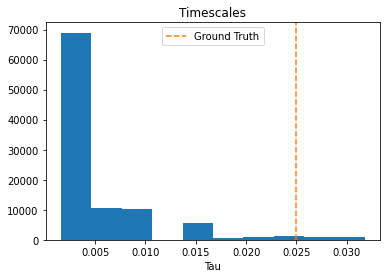

In [16]:
from timescales.fit import convert_knee_val
knees = np.array([convert_knee_val(i) for i in params[:, 0]])

plt.hist(knees)
plt.axvline(tau, ls='--', color='C1', label='Ground Truth')
plt.title('Timescales')
plt.xlabel('Tau')
plt.legend();

Text(0.5, 0, 'R^2')

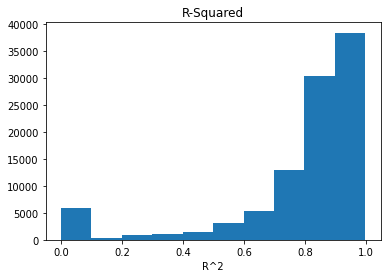

In [17]:
plt.hist(params[:, 1])
plt.title('R-Squared')
plt.xlabel('R^2')

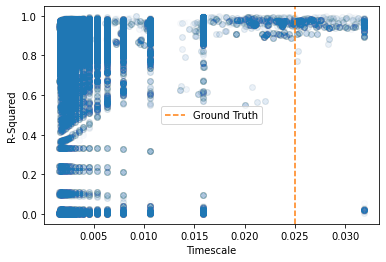

In [25]:
plt.scatter(knees, params[:, 1], alpha=.01)
plt.xlabel('Timescale')
plt.ylabel('R-Squared')
plt.axvline(tau, color='C1', ls='--', label='Ground Truth')
plt.legend();